In [1]:
import torchvision
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm
import torch
import ImageData
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time

In [2]:
model_name = "densenet"
model_image_size = 224
# vit = models.vit_l_16(models.ViT_L_16_Weights.IMAGENET1K_V1)

In [3]:
class DenseNet(torch.nn.Module):
    def __init__(self, numClasses: int, softmax:bool = True):
        super(DenseNet, self).__init__()

        self.densenetBase = torchvision.models.densenet121(weights='DEFAULT')
        self.features = self.densenetBase.features
        self.relu = torch.nn.ReLU()
        self.avgPool = torch.nn.AdaptiveMaxPool2d((1,1))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 216),
            torch.nn.ReLU(),
            torch.nn.Linear(216, 4)
        )
        
        for param in list(self.densenetBase.parameters())[:-1]:
            param.requires_grad = True
        # for param in self.inceptionBase.parameters():
        #     print(param.requires_grad)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        features = self.features(x)
        out = self.relu(features)
        out = self.avgPool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

In [4]:
model = DenseNet(4).to(device)
# print(*list(model.children())[:-1])

In [5]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainDataLoader, validDataLoader, testDataLoader = ImageData.getImagesDataloaders("./ArtiFact/", transforms = transform, batchSize=batch_size)

In [7]:
dataset = trainDataLoader.dataset

In [8]:
from torch.utils.data import Subset, DataLoader

In [9]:
trainSub = Subset(dataset, range(100))

In [15]:
trainSubDataloader = DataLoader(trainSub, batch_size=32)

In [16]:
def evaluate_on_data(model, dataloader, dirty: bool = False):
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        total_loss = 0
        
        num_correct = 0.0
        num_samples = 0.0
        for data in tqdm(dataloader, desc="Eval: "):
            image, label = data
            label = label.to(device)
            image = image.to(device)
            outputs = model(image)
            loss = criterion(outputs, label)
            total_loss += loss.item()

            if dirty:
                outputs = torch.where(outputs > 1, torch.tensor(1, dtype = torch.int32), outputs)
                

            argMax = torch.argmax(outputs, 1)
            for i in range(len(label)):
                if label[i] == argMax[i]:
                    num_correct += 1

                num_samples += 1
                    
                
                
    return total_loss / len(dataloader), num_correct / num_samples

In [19]:
num_epochs = 15
count = 0
valid_loss_array = np.zeros(num_epochs)
valid_acc_array = np.zeros(num_epochs)
valid_loss_dirty_array = np.zeros(num_epochs)
valid_acc_dirty_array = np.zeros(num_epochs)

train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    batch_count = 0
    for data in tqdm(trainDataLoader, desc="Training: "):
        
        image, label= data
        
        label = label.to(device)
        image = image.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        count += 1
            
        
    valid_loss, valid_acc = evaluate_on_data(model, validDataLoader)
    valid_loss_dirty, valid_acc_dirty = evaluate_on_data(model, validDataLoader, dirty=True)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid ACC: {valid_acc}, Dirty Valid Loss: {valid_loss_dirty}, Dirty Valid ACC: {valid_acc_dirty}')
    valid_loss_array[epoch] = valid_loss
    train_loss_array[epoch] = loss.item()
    valid_acc_array[epoch] = valid_acc
    valid_loss_dirty_array[epoch] = valid_loss
    valid_acc_dirty_array[epoch] = valid_acc




Training:   0%|          | 26/116172 [00:27<33:39:58,  1.04s/it]


KeyboardInterrupt: 

In [20]:
with open(model_name + '_valid_loss.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    
with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)

with open(model_name + '_valid_dirty_loss.npy', 'wb') as f:
    np.save(f, valid_loss_dirty_array)
    
with open(model_name + '_valid_dirty_acc.npy', 'wb') as f:
    np.save(f, valid_acc_dirty_array)
    
with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)

In [21]:
import matplotlib.pyplot as plt

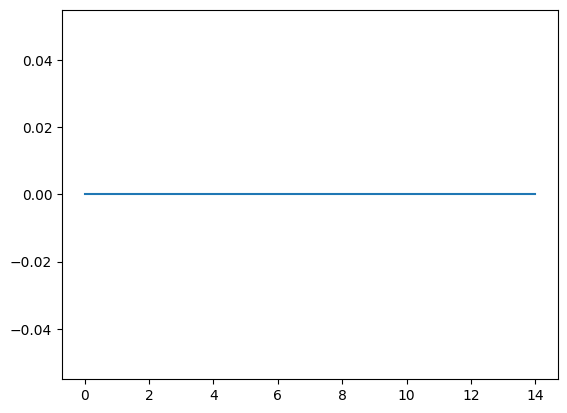

In [23]:
plt.plot(valid_loss_array)